In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



import os
import glob

In [37]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [38]:
# VAE CONDITIONS
n_conds = 40
latent_dim = 100

attrib_inputs = Input(shape=(n_conds,), name='attrib_input')

x = Dense(256)(attrib_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)


u_mean = Dense(latent_dim, name='u_mean')(x)
u_log_var = Dense(latent_dim, name='u_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
u = Lambda(sampling, output_shape=(latent_dim,), name='u')([u_mean, u_log_var])

attrib_encoder = Model(attrib_inputs, [u_mean, u_log_var, u], name='attrib_encoder')
attrib_encoder.summary()

latent_attrib_inputs = Input(shape=(latent_dim,), name='u_sampling')

x = Dense(128)(latent_attrib_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

attrib_outputs = Dense(n_conds, activation='tanh')(x)

attrib_decoder = Model(latent_attrib_inputs, attrib_outputs, name='attrib_decoder')
attrib_decoder.summary()

attrib_outputs = attrib_decoder(attrib_encoder(attrib_inputs)[2])
attrib2attrib_vae = Model(attrib_inputs, [attrib_outputs, u_mean, u_log_var], name='attrib2attrib_vae')
attrib2attrib_vae.summary()



Model: "attrib_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attrib_input (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 256)          10496       attrib_input[0][0]               
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 256)          1024        dense_24[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_42 (LeakyReLU)      (None, 256)          0           batch_normalization_42[0][0]     
_____________________________________________________________________________________

In [39]:
# VAE IMAGE
# network parameters
width = 64
height = 64
latent_dim = 100
inner_latent = 256



# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')

x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='img_encoder')
encoder.summary()



# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')




x = Dense(h*w*c, activation='relu')(latent_inputs)
x = Reshape((h,w,c))(x)
x = Conv2D(128,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='tanh', padding='same')(x)


# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='img_decoder')
decoder.summary()

# # instantiate VAE model




outputs = decoder(encoder(inputs)[2])
img2img_vae = Model(inputs, [outputs, z_mean, z_log_var], name='img2img_vae')
img2img_vae.summary()


Model: "img_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 32, 32, 16)   64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_48 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_48[0][0]     
________________________________________________________________________________________

In [40]:
attrib_outputs = attrib_decoder(encoder(inputs)[2])
img2attrib_vae = Model(inputs, [attrib_outputs, z_mean, z_log_var], name='img2attrib_vae')
img2attrib_vae.summary()

outputs = decoder(attrib_encoder(attrib_inputs)[2])
attrib2img_vae = Model(attrib_inputs, [outputs, u_mean, u_log_var], name='attrib2img_vae')
attrib2img_vae.summary()

Model: "img2attrib_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 32, 32, 16)   64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_48 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_48[0][0]     
_____________________________________________________________________________________

In [41]:
img2img_optimizer = tf.keras.optimizers.Adam(1e-4)
attrib2attrib_optimizer = tf.keras.optimizers.Adam(1e-4)
attrib2img_optimizer = tf.keras.optimizers.Adam(1e-4)
img2attrib_optimizer = tf.keras.optimizers.Adam(1e-4)
ssl_img_optimizer = tf.keras.optimizers.Adam(1e-4)
ssl_attrib_optimizer = tf.keras.optimizers.Adam(1e-4)

In [42]:
@tf.function
def kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(kl_loss)
@tf.function
def reconstruction_loss(y_true, y_pred):
    return mse(K.flatten(y_true), K.flatten(y_pred))
@tf.function
def space_sharing_loss(z, u):
    return K.mean(K.sqrt(K.sum(K.square(z - u), axis=-1)))

In [43]:
@tf.function
def train_step(images, attributes):

    with tf.GradientTape() as img2img_tape, tf.GradientTape() as attrib2attrib_tape, tf.GradientTape() as img2attrib_tape, tf.GradientTape() as attrib2img_tape, tf.GradientTape() as ss_img_tape, tf.GradientTape() as ss_attrib_tape:
        
        reconstructed_images, z_mean, z_log_var = img2img_vae(images, training=True)
        rl_img2img = reconstruction_loss(images, reconstructed_images)
        kl_img = kl_loss(z_mean, z_log_var)
        loss_img2img = rl_img2img*64*64 + kl_img
        
        reconstructed_attributes, u_mean, u_log_var = attrib2attrib_vae(attributes, training=True)
        rl_attrib2attrib = reconstruction_loss(attributes, reconstructed_attributes)
        kl_attrib = kl_loss(u_mean, u_log_var)
        loss_attrib2attrib = rl_attrib2attrib*40 + kl_attrib
        
        generated_images, _, _ = attrib2img_vae(attributes, training=True)
        rl_attrib2img = reconstruction_loss(images, generated_images)*64*64
        
        generated_attributes, _, _ = img2attrib_vae(images, training=True)
        rl_img2attrib = reconstruction_loss(attributes, generated_attributes)*40
        
        _, _, sampled_u = attrib_encoder(attributes,training=True)
        _, _, sampled_z = encoder(images,training=True)
        
        loss_ss = space_sharing_loss(sampled_z, sampled_u)




    gradients_of_img2img = img2img_tape.gradient(loss_img2img, img2img_vae.trainable_variables)
    gradients_of_attrib2attrib = attrib2attrib_tape.gradient(loss_attrib2attrib, attrib2attrib_vae.trainable_variables)
    gradients_of_img2attrib = img2attrib_tape.gradient(rl_img2attrib, img2attrib_vae.trainable_variables)
    gradients_of_attrib2img = attrib2img_tape.gradient(rl_attrib2img, attrib2img_vae.trainable_variables)    
    gradients_of_ss_img = ss_img_tape.gradient(loss_ss, encoder.trainable_variables)
    gradients_of_ss_attrib = ss_attrib_tape.gradient(loss_ss, attrib_encoder.trainable_variables)
    
    
    ssl_img_optimizer.apply_gradients(zip(gradients_of_ss_img, encoder.trainable_variables))
    ssl_attrib_optimizer.apply_gradients(zip(gradients_of_ss_attrib, attrib_encoder.trainable_variables))
    
    img2img_optimizer.apply_gradients(zip(gradients_of_img2img, img2img_vae.trainable_variables))
    attrib2attrib_optimizer.apply_gradients(zip(gradients_of_attrib2attrib, attrib2attrib_vae.trainable_variables))
    img2attrib_optimizer.apply_gradients(zip(gradients_of_img2attrib, img2attrib_vae.trainable_variables))
    attrib2img_optimizer.apply_gradients(zip(gradients_of_attrib2img, attrib2img_vae.trainable_variables))
    

    return loss_ss, loss_img2img, loss_attrib2attrib, rl_attrib2img, rl_img2attrib

In [9]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [10]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present == 1:
            print(attrib)

In [11]:
df = pd.read_csv('./celeba-attribs.csv')

In [12]:
training_data_generator = ImageDataGenerator(
    validation_split=0.8,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=40520,
    class_mode='raw')


Found 40520 validated image filenames.


In [13]:
training_data = training_generator.next()

In [44]:
import time
epochs = 1001
batch_size = 32

model_type = '10kimgs-cross-vae'

training_imgs = training_data[0]
training_cond = training_data[1]
num_batches = len(training_imgs) // batch_size

loss_ss_list = []
loss_img2img_list = []
loss_attrib2attrib_list = [] 
rl_attrib2img_list = []
rl_img2attrib_list = []



for epoch in range(0,epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')

    np.random.seed(epoch)
    np.random.shuffle(training_imgs)
    np.random.seed(epoch)
    np.random.shuffle(training_cond)
    
    loss_ss_total = 0 
    loss_img2img_total = 0
    loss_attrib2attrib_total = 0 
    rl_attrib2img_total = 0
    rl_img2attrib_total = 0
    for index in range(num_batches):
        img_input = training_imgs[index*batch_size: batch_size*(index+1)]
        condition_input = training_cond[index*batch_size: batch_size*(index+1)]
        
        loss_ss, loss_img2img, loss_attrib2attrib, rl_attrib2img, rl_img2attrib = train_step(img_input, condition_input)
        loss_ss_total += K.get_value(loss_ss)
        loss_img2img_total += K.get_value(loss_img2img)
        loss_attrib2attrib_total += K.get_value(loss_attrib2attrib)
        rl_attrib2img_total += K.get_value(rl_attrib2img)
        rl_img2attrib_total += K.get_value(rl_img2attrib)
    

    loss_ss_list.append(loss_ss_total/num_batches)
    loss_img2img_list.append(loss_img2img_total/num_batches)
    loss_attrib2attrib_list.append(loss_attrib2attrib_total/num_batches)
    rl_attrib2img_list.append(rl_attrib2img_total/num_batches)
    rl_img2attrib_list.append(rl_img2attrib_total/num_batches)

    
    print(f'...{time.time()-start:.3f}(s)  ss: {loss_ss_total/num_batches:.3f} - img2img: {loss_img2img_total/num_batches:.3f} - attrib2attrib: {loss_attrib2attrib_total/num_batches:.3f} - attrib2img: {rl_attrib2img_total/num_batches:.3f} - img2attrib: {rl_img2attrib_total/num_batches:.3f}')
    if epoch % 100 == 0:
        print(f'checkpointing at epoch: {epoch}')
        decoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-decoder-weights.h5')
        decoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-decoder.h5')
        encoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-encoder-weights.h5')
        encoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-encoder.h5')
        attrib_decoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-attrib-decoder-weights.h5')
        attrib_decoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-attrib-decoder.h5')
        attrib_encoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-attrib-encoder-weights.h5')
        attrib_encoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-attrib-encoder.h5')


Epoch [0/1000]...   ...57.658(s)  ss: 9.199 - img2img: 668.679 - attrib2attrib: 32.861 - attrib2img: 1312.962 - img2attrib: 20.481
checkpointing at epoch: 0
Epoch [1/1000]...   ...50.647(s)  ss: 7.740 - img2img: 570.267 - attrib2attrib: 28.441 - attrib2img: 1266.374 - img2attrib: 16.529
Epoch [2/1000]...   ...50.980(s)  ss: 7.390 - img2img: 563.342 - attrib2attrib: 29.371 - attrib2img: 1255.982 - img2attrib: 15.704
Epoch [3/1000]...   ...51.071(s)  ss: 7.188 - img2img: 558.881 - attrib2attrib: 30.361 - attrib2img: 1248.838 - img2attrib: 15.217
Epoch [4/1000]...   ...51.057(s)  ss: 7.026 - img2img: 551.682 - attrib2attrib: 31.529 - attrib2img: 1242.565 - img2attrib: 14.880
Epoch [5/1000]...   ...50.245(s)  ss: 6.914 - img2img: 545.818 - attrib2attrib: 32.696 - attrib2img: 1240.066 - img2attrib: 14.646
Epoch [6/1000]...   ...49.412(s)  ss: 6.806 - img2img: 540.258 - attrib2attrib: 33.883 - attrib2img: 1235.104 - img2attrib: 14.464
Epoch [7/1000]...   ...49.505(s)  ss: 6.732 - img2img: 53

Epoch [63/1000]...  ...51.421(s)  ss: 5.227 - img2img: 549.158 - attrib2attrib: 74.622 - attrib2img: 1204.722 - img2attrib: 13.341
Epoch [64/1000]...  ...51.480(s)  ss: 5.245 - img2img: 548.421 - attrib2attrib: 74.541 - attrib2img: 1203.687 - img2attrib: 13.324
Epoch [65/1000]...  ...51.495(s)  ss: 5.249 - img2img: 549.336 - attrib2attrib: 74.592 - attrib2img: 1203.762 - img2attrib: 13.286
Epoch [66/1000]...  ...51.372(s)  ss: 5.237 - img2img: 549.659 - attrib2attrib: 74.860 - attrib2img: 1203.174 - img2attrib: 13.284
Epoch [67/1000]...  ...51.449(s)  ss: 5.248 - img2img: 550.692 - attrib2attrib: 74.983 - attrib2img: 1204.246 - img2attrib: 13.294
Epoch [68/1000]...  ...51.359(s)  ss: 5.279 - img2img: 549.955 - attrib2attrib: 74.601 - attrib2img: 1204.292 - img2attrib: 13.330
Epoch [69/1000]...  ...50.341(s)  ss: 5.287 - img2img: 550.373 - attrib2attrib: 74.533 - attrib2img: 1204.153 - img2attrib: 13.335
Epoch [70/1000]...  ...49.368(s)  ss: 5.288 - img2img: 550.974 - attrib2attrib: 74.

Epoch [126/1000]... ...51.356(s)  ss: 5.914 - img2img: 550.235 - attrib2attrib: 66.356 - attrib2img: 1202.641 - img2attrib: 13.768
Epoch [127/1000]... ...51.394(s)  ss: 5.937 - img2img: 550.764 - attrib2attrib: 66.467 - attrib2img: 1203.521 - img2attrib: 13.749
Epoch [128/1000]... ...51.302(s)  ss: 5.937 - img2img: 550.502 - attrib2attrib: 66.534 - attrib2img: 1202.412 - img2attrib: 13.812
Epoch [129/1000]... ...51.521(s)  ss: 5.935 - img2img: 549.423 - attrib2attrib: 66.904 - attrib2img: 1202.492 - img2attrib: 13.862
Epoch [130/1000]... ...51.459(s)  ss: 5.936 - img2img: 548.063 - attrib2attrib: 67.109 - attrib2img: 1201.800 - img2attrib: 13.868
Epoch [131/1000]... ...51.366(s)  ss: 5.912 - img2img: 547.021 - attrib2attrib: 67.803 - attrib2img: 1202.458 - img2attrib: 13.901
Epoch [132/1000]... ...51.458(s)  ss: 5.896 - img2img: 548.925 - attrib2attrib: 67.873 - attrib2img: 1201.650 - img2attrib: 13.944
Epoch [133/1000]... ...49.718(s)  ss: 5.908 - img2img: 550.072 - attrib2attrib: 68.

Epoch [189/1000]... ...49.383(s)  ss: 4.931 - img2img: 615.606 - attrib2attrib: 89.344 - attrib2img: 1202.094 - img2attrib: 14.009
Epoch [190/1000]... ...49.372(s)  ss: 4.913 - img2img: 627.471 - attrib2attrib: 90.020 - attrib2img: 1201.042 - img2attrib: 13.994
Epoch [191/1000]... ...49.359(s)  ss: 4.906 - img2img: 629.899 - attrib2attrib: 90.509 - attrib2img: 1200.837 - img2attrib: 13.957
Epoch [192/1000]... ...49.794(s)  ss: 4.915 - img2img: 625.106 - attrib2attrib: 91.031 - attrib2img: 1202.504 - img2attrib: 13.974
Epoch [193/1000]... ...50.818(s)  ss: 4.896 - img2img: 619.078 - attrib2attrib: 91.286 - attrib2img: 1200.903 - img2attrib: 14.047
Epoch [194/1000]... ...50.886(s)  ss: 4.876 - img2img: 629.623 - attrib2attrib: 92.081 - attrib2img: 1201.622 - img2attrib: 14.433
Epoch [195/1000]... ...50.659(s)  ss: 4.803 - img2img: 620.714 - attrib2attrib: 92.826 - attrib2img: 1201.790 - img2attrib: 14.319
Epoch [196/1000]... ...50.819(s)  ss: 4.793 - img2img: 619.566 - attrib2attrib: 93.

Epoch [251/1000]... ...50.452(s)  ss: 4.853 - img2img: 656.648 - attrib2attrib: 98.153 - attrib2img: 1200.899 - img2attrib: 14.205
Epoch [252/1000]... ...50.262(s)  ss: 4.920 - img2img: 630.369 - attrib2attrib: 98.535 - attrib2img: 1201.555 - img2attrib: 14.333
Epoch [253/1000]... ...50.256(s)  ss: 4.936 - img2img: 630.244 - attrib2attrib: 99.080 - attrib2img: 1200.979 - img2attrib: 14.427
Epoch [254/1000]... ...49.238(s)  ss: 4.974 - img2img: 650.302 - attrib2attrib: 99.092 - attrib2img: 1201.192 - img2attrib: 14.634
Epoch [255/1000]... ...49.204(s)  ss: 5.099 - img2img: 715.748 - attrib2attrib: 98.952 - attrib2img: 1202.468 - img2attrib: 14.814
Epoch [256/1000]... ...50.153(s)  ss: 4.893 - img2img: 666.190 - attrib2attrib: 100.132 - attrib2img: 1200.713 - img2attrib: 14.364
Epoch [257/1000]... ...50.348(s)  ss: 5.152 - img2img: 726.225 - attrib2attrib: 98.966 - attrib2img: 1201.607 - img2attrib: 14.711
Epoch [258/1000]... ...50.497(s)  ss: 4.870 - img2img: 791.582 - attrib2attrib: 10

Epoch [313/1000]... ...49.355(s)  ss: 5.124 - img2img: 666.553 - attrib2attrib: 105.527 - attrib2img: 1202.118 - img2attrib: 14.386
Epoch [314/1000]... ...49.478(s)  ss: 5.028 - img2img: 636.995 - attrib2attrib: 106.608 - attrib2img: 1202.137 - img2attrib: 14.231
Epoch [315/1000]... ...49.540(s)  ss: 5.044 - img2img: 676.059 - attrib2attrib: 107.448 - attrib2img: 1202.525 - img2attrib: 14.191
Epoch [316/1000]... ...49.476(s)  ss: 5.010 - img2img: 687.801 - attrib2attrib: 106.924 - attrib2img: 1201.224 - img2attrib: 14.122
Epoch [317/1000]... ...49.866(s)  ss: 5.014 - img2img: 686.403 - attrib2attrib: 107.702 - attrib2img: 1202.679 - img2attrib: 14.169
Epoch [318/1000]... ...51.443(s)  ss: 4.963 - img2img: 689.262 - attrib2attrib: 107.084 - attrib2img: 1201.923 - img2attrib: 14.134
Epoch [319/1000]... ...51.492(s)  ss: 4.974 - img2img: 705.850 - attrib2attrib: 107.397 - attrib2img: 1201.934 - img2attrib: 14.119
Epoch [320/1000]... ...51.382(s)  ss: 4.961 - img2img: 730.614 - attrib2attr

Epoch [375/1000]... ...49.418(s)  ss: 4.302 - img2img: 702.561 - attrib2attrib: 304.390 - attrib2img: 1191.337 - img2attrib: 14.312
Epoch [376/1000]... ...49.418(s)  ss: 4.262 - img2img: 666.724 - attrib2attrib: 327.456 - attrib2img: 1191.068 - img2attrib: 14.360
Epoch [377/1000]... ...51.158(s)  ss: 4.312 - img2img: 662.059 - attrib2attrib: 341.538 - attrib2img: 1190.890 - img2attrib: 14.335
Epoch [378/1000]... ...51.385(s)  ss: 4.270 - img2img: 668.689 - attrib2attrib: 345.604 - attrib2img: 1191.534 - img2attrib: 14.291
Epoch [379/1000]... ...51.396(s)  ss: 4.285 - img2img: 690.621 - attrib2attrib: 344.468 - attrib2img: 1191.598 - img2attrib: 14.298
Epoch [380/1000]... ...51.321(s)  ss: 4.217 - img2img: 779.623 - attrib2attrib: 347.651 - attrib2img: 1192.032 - img2attrib: 14.328
Epoch [381/1000]... ...51.559(s)  ss: 3.958 - img2img: 916.750 - attrib2attrib: 352.864 - attrib2img: 1192.233 - img2attrib: 14.373
Epoch [382/1000]... ...51.535(s)  ss: 4.059 - img2img: 978.319 - attrib2attr

Epoch [437/1000]... ...51.205(s)  ss: 4.817 - img2img: 802.020 - attrib2attrib: 111.924 - attrib2img: 1199.632 - img2attrib: 14.189
Epoch [438/1000]... ...51.336(s)  ss: 4.853 - img2img: 784.090 - attrib2attrib: 109.983 - attrib2img: 1200.276 - img2attrib: 14.102
Epoch [439/1000]... ...51.241(s)  ss: 4.727 - img2img: 810.531 - attrib2attrib: 122.681 - attrib2img: 1198.058 - img2attrib: 14.098
Epoch [440/1000]... ...51.232(s)  ss: 4.649 - img2img: 777.045 - attrib2attrib: 121.829 - attrib2img: 1199.708 - img2attrib: 14.053
Epoch [441/1000]... ...51.257(s)  ss: 4.718 - img2img: 804.096 - attrib2attrib: 117.829 - attrib2img: 1199.669 - img2attrib: 14.059
Epoch [442/1000]... ...51.338(s)  ss: 4.680 - img2img: 866.654 - attrib2attrib: 116.116 - attrib2img: 1199.951 - img2attrib: 13.971
Epoch [443/1000]... ...51.447(s)  ss: 4.871 - img2img: 1048.950 - attrib2attrib: 112.170 - attrib2img: 1201.008 - img2attrib: 14.002
Epoch [444/1000]... ...51.291(s)  ss: 4.936 - img2img: 1143.058 - attrib2at

Epoch [499/1000]... ...51.423(s)  ss: 4.678 - img2img: 684.176 - attrib2attrib: 113.407 - attrib2img: 1200.000 - img2attrib: 14.084
Epoch [500/1000]... ...51.508(s)  ss: 4.610 - img2img: 660.466 - attrib2attrib: 115.915 - attrib2img: 1200.824 - img2attrib: 14.035
checkpointing at epoch: 500
Epoch [501/1000]... ...51.395(s)  ss: 4.543 - img2img: 659.696 - attrib2attrib: 116.167 - attrib2img: 1200.189 - img2attrib: 14.017
Epoch [502/1000]... ...50.254(s)  ss: 4.666 - img2img: 670.556 - attrib2attrib: 113.772 - attrib2img: 1200.335 - img2attrib: 14.095
Epoch [503/1000]... ...49.309(s)  ss: 4.545 - img2img: 625.334 - attrib2attrib: 114.277 - attrib2img: 1200.400 - img2attrib: 14.044
Epoch [504/1000]... ...51.314(s)  ss: 4.549 - img2img: 616.487 - attrib2attrib: 113.362 - attrib2img: 1200.684 - img2attrib: 14.018
Epoch [505/1000]... ...51.469(s)  ss: 4.631 - img2img: 632.611 - attrib2attrib: 114.003 - attrib2img: 1201.886 - img2attrib: 14.120
Epoch [506/1000]... ...51.329(s)  ss: 4.671 - im

KeyboardInterrupt: 

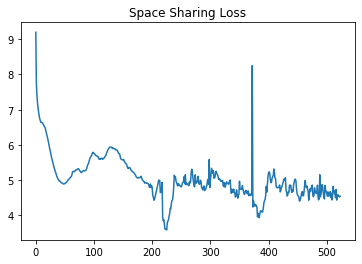

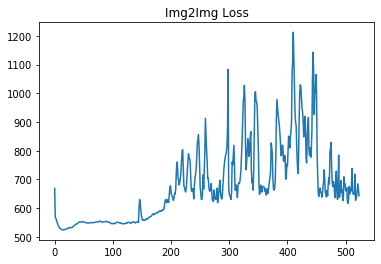

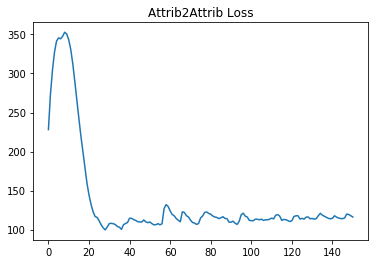

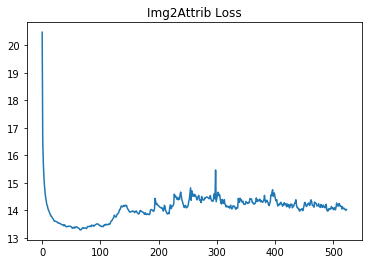

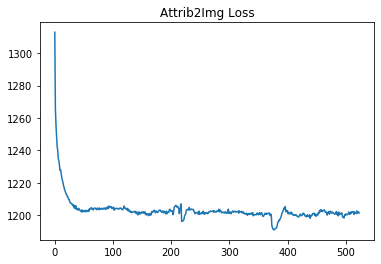

In [97]:
plt.plot(loss_ss_list)
plt.title("Space Sharing Loss")
plt.show()

plt.plot(loss_img2img_list)
plt.title("Img2Img Loss")
plt.show()

plt.plot(loss_attrib2attrib_list[373:])
plt.title("Attrib2Attrib Loss")
plt.show()

plt.plot(rl_img2attrib_list)
plt.title("Img2Attrib Loss")
plt.show()

plt.plot(rl_attrib2img_list)
plt.title("Attrib2Img Loss")
plt.show()

In [45]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label

In [46]:
attribs = '''5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young'''
attribs = attribs.split('=1,')
attribs = [attrib.strip() for attrib in attribs]
print(f"=1, ".join(attribs))

5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young


In [47]:
attrib_dict = {attrib:i for i,attrib in enumerate(attribs)}

In [48]:
sliders = []
labels = []
for attrib in attribs:
    slider = widgets.FloatSlider(
        min=-3,
        max=3,
        step=0.5,
        value=-1
    )
    labels.append(Label(attrib))
    sliders.append(slider)
for label, slider in zip(labels,sliders):
    display(label)
    display(slider)

Label(value='5oClockShadow')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Arched_Eyebrows')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Attractive')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Bags_Under_Eyes')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Bald')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Bangs')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Big_Lips')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Big_Nose')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Black_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Blond_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Blurry')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Brown_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Bushy_Eyebrows')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Chubby')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Double_Chin')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Eyeglasses')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Goatee')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Gray_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Heavy_Makeup')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='High_Cheekbones')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Male')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Mouth_Slightly_Open')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Mustache')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Narrow_Eyes')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='No_Beard')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Oval_Face')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Pale_Skin')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Pointy_Nose')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Receding_Hairline')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Rosy_Cheeks')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Sideburns')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Smiling')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Straight_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wavy_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wearing_Earrings')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wearing_Hat')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wearing_Lipstick')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wearing_Necklace')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Wearing_Necktie')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value='Young')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

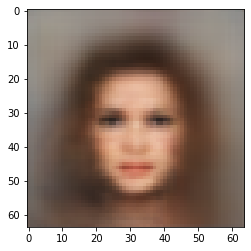

In [90]:
conditions = np.array([slider.value for slider in sliders])
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma,latent_dim)
#gen_img = unnormalize_tanh( decoder.predict(np.array([s]))[0])
gen_img = unnormalize_tanh(attrib2img_vae.predict(np.array([conditions]))[0][0])
plt.imshow(gen_img)
plt.show()

In [67]:
attrib2img_vae.predict(np.array([conditions]))[0][0]


array([[[-0.27482632, -0.28974175, -0.33482152],
        [-0.3233533 , -0.3233983 , -0.32831278],
        [-0.33972523, -0.33851033, -0.34276333],
        ...,
        [-0.285833  , -0.2541368 , -0.24994692],
        [-0.2725085 , -0.23159263, -0.22329782],
        [-0.22486493, -0.231483  , -0.24946032]],

       [[-0.3363715 , -0.33812085, -0.34822342],
        [-0.3351037 , -0.32807592, -0.32984352],
        [-0.32974172, -0.3274479 , -0.34024337],
        ...,
        [-0.28209937, -0.24392428, -0.245913  ],
        [-0.26682517, -0.22485955, -0.21668161],
        [-0.24326481, -0.21043651, -0.21407153]],

       [[-0.34590665, -0.35487628, -0.35679904],
        [-0.34607312, -0.34288615, -0.34650582],
        [-0.31799132, -0.3255935 , -0.34106418],
        ...,
        [-0.27073014, -0.24192722, -0.2484501 ],
        [-0.26336595, -0.22575785, -0.22836171],
        [-0.23681405, -0.21135038, -0.21701899]],

       ...,

       [[-0.1970159 , -0.29358003, -0.32198384],
        [-0

In [488]:
import os

def attrib_sweep(model, attribs,  noise, init_conditions, start, stop, steps, wieghts=[], save=False, show=True, make_gif=False):
    
    conditions = init_conditions.copy()
    if wieghts == []:
        wieghts = [1] * len(attribs)
    print(f'Sweeping {"&".join(attribs)} from {start} to {stop} in {steps} steps.')
    if save:
        try:
            os.mkdir(f'./attribute_sweeps/{attrib}/')
        except OSError as error: 
            print(error)
    frames = []
    for j,i in enumerate(np.linspace(start,stop,steps)):
        for attrib, wieght in zip(attribs,wieghts):
            idx = attrib_dict[attrib]
            conditions[idx] = i*wieght
        gen_img = unnormalize_tanh( model.predict([np.array([s]),np.array([conditions])])[0])
        if show:
            plt.imshow(gen_img)
            plt.axis('off')
            if save:
                plt.savefig(f'./attribute_sweeps/{"_".join(attribs)}/({j})_{i}_{"_".join(attribs)}.png')
            plt.show()
        if make_gif:
            frames.append(Image.fromarray((gen_img * 255).astype(np.uint8)).resize((256,256)))
            
    if make_gif:
        frames[0].save(f'{"&".join(attribs)}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

In [498]:
# sweep attribs with wieghts

for attrib in attribs:
    attrib_sweep(decoder_big, [attrib], s, conditions, -5,5,20,wieghts=wieghts,show=False, save=False, make_gif=True)

Sweeping 5oClockShadow from -5 to 5 in 20 steps.
Sweeping Arched_Eyebrows from -5 to 5 in 20 steps.
Sweeping Attractive from -5 to 5 in 20 steps.
Sweeping Bags_Under_Eyes from -5 to 5 in 20 steps.
Sweeping Bald from -5 to 5 in 20 steps.
Sweeping Bangs from -5 to 5 in 20 steps.
Sweeping Big_Lips from -5 to 5 in 20 steps.
Sweeping Big_Nose from -5 to 5 in 20 steps.
Sweeping Black_Hair from -5 to 5 in 20 steps.
Sweeping Blond_Hair from -5 to 5 in 20 steps.
Sweeping Blurry from -5 to 5 in 20 steps.
Sweeping Brown_Hair from -5 to 5 in 20 steps.
Sweeping Bushy_Eyebrows from -5 to 5 in 20 steps.
Sweeping Chubby from -5 to 5 in 20 steps.
Sweeping Double_Chin from -5 to 5 in 20 steps.
Sweeping Eyeglasses from -5 to 5 in 20 steps.
Sweeping Goatee from -5 to 5 in 20 steps.
Sweeping Gray_Hair from -5 to 5 in 20 steps.
Sweeping Heavy_Makeup from -5 to 5 in 20 steps.
Sweeping High_Cheekbones from -5 to 5 in 20 steps.
Sweeping Male from -5 to 5 in 20 steps.
Sweeping Mouth_Slightly_Open from -5 to 5 i

In [216]:
# attribs to choose from
" ".join(attribs)

'5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  Blurry  Brown_Hair  Bushy_Eyebrows  Chubby  Double_Chin  Eyeglasses  Goatee  Gray_Hair  Heavy_Makeup  High_Cheekbones  Male  Mouth_Slightly_Open  Mustache  Narrow_Eyes  No_Beard  Oval_Face  Pale_Skin  Pointy_Nose  Receding_Hairline  Rosy_Cheeks  Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young'

In [281]:
def make_gif(attrib):
    frames = []
    print(attrib)
    imgs = glob.glob(f"./attribute_sweeps/{attrib}/*.png")
    imgs = sorted(imgs, key=lambda x: int(re.search(r'\(([0-9]+)\)', x).group(1)))

    for i in imgs:
        print(f'processing {i}')
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(f'{attrib}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

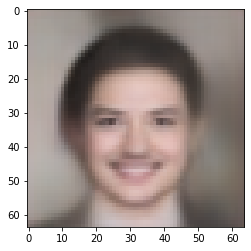

In [517]:
mu, sigma = 0, 1 #mean and standard deviation
z = np.random.normal(mu, sigma,64)
u = inner_decoder.predict(np.array([z]))
plt.imshow(unnormalize_tanh( decoder.predict([u,np.array([conditions])])[0]))
plt.show()

(1, 100)